# 🦄 Unicorn Investor Network Analysis

### Overview

This Jupyter notebook analyzes the **2024 Unicorn and Emerging Unicorn Companies** dataset sourced from Kaggle. The dataset contains information on unicorn companies (privately held startups valued at over $1 billion) and emerging unicorns, along with details on their valuation, industry, country, and investors. By examining the relationships between these companies and their investors, we aim to identify the most **central investors** and explore the **network structure** within the global unicorn ecosystem.

This dataset is based on the **Crunchbase Unicorn and Emerging Unicorns list**.

- **Unicorns Dataset**: Includes private unicorn companies with post-money valuations of **$1 Billion or More**, and is based on Crunchbase data.

- **Emerging Unicorns Dataset**: Includes private companies with valuations of **$500 million or more but less than $1 billion**, based on Crunchbase data.

### Dataset Description

The **Unicorn and Emerging Unicorn Companies** dataset includes the following key fields:
- **Company**: The name of the unicorn or emerging unicorn company.
- **Valuation**: The company's valuation, either over $1 billion (unicorns) or between $500 million and $1 billion (emerging unicorns).
- **Industry**: The industry sector in which the company operates (e.g., Fintech, Artificial Intelligence, E-commerce).
- **Country**: The country where the company is headquartered.
- **Investors**: A list of investors who have provided funding to the company.

This dataset serves as the foundation for creating a **bipartite graph** (a graph with two distinct sets of nodes), where:
- **Companies** form one set of nodes.
- **Investors** form the second set of nodes.
- **Edges** between these nodes represent the financial relationships between companies and their investors.

By projecting this bipartite graph into an investor-investor network, we can conduct a detailed **network analysis** that identifies key investors and their roles in funding unicorn companies across various industries and geographies.

### Objective of the Analysis

The primary objective of this analysis is to explore and analyze the **investor network** in the unicorn ecosystem, with a focus on answering the following key questions:
- **Which investors are the most central or influential in the unicorn ecosystem?**
- **How are different industries and investors interconnected through these companies?**
- **Are there any geographic or industry-specific patterns in investor influence?**

### Methodology

To achieve this, we will:
1. **Load and clean the dataset**, ensuring that the investor data is properly structured for analysis.
2. **Create a bipartite graph** representing the relationships between unicorn companies and their investors.
3. **Project the bipartite graph** into an investor network to analyze how investors are connected to each other through their investments.
4. Apply **centrality measures** (degree centrality, betweenness centrality) to identify the most important investors in the network.
5. **Visualize the network** to highlight key players and patterns.
6. Provide insights and conclusions based on the analysis, with potential applications for investors, startups, and researchers interested in the dynamics of the unicorn ecosystem.

### Tools and Libraries

This analysis will use the following Python libraries:
- **pandas**: For data manipulation and exploration.
- **networkx**: For constructing and analyzing the network graph.
- **matplotlib & seaborn**: For creating visualizations.
- **numpy**: For efficient numerical computations.

### Expected Outcomes

By the end of this notebook, we expect to have a clear understanding of:
- **Key investors** driving the unicorn ecosystem.
- The **structure of the investor network**, including central hubs and industry-specific clusters.
- How **centrality measures** can be used to identify influential nodes (investors) in the context of venture capital and startup funding.

This notebook aims to use **data science and network analysis techniques** learned in INST414 to provide valuable insights into the global unicorn investment landscape.

In [2]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Graph/network analysis libraries
import networkx as nx

# Configure visualizations
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

In [3]:
# Load the unicorn companies dataset
unicorn_df = pd.read_csv("unicorn_companies.csv")

# Load the emerging unicorn companies dataset
emerging_unicorn_df = pd.read_csv("emergingunicorn_companies.csv")

# Check the first few rows of each dataset
print("Unicorn Companies")
print(unicorn_df.head())

print("\nEmerging Unicorn Companies")
print(emerging_unicorn_df.head())

Unicorn Companies
   Unnamed: 0        country         region  \
0           0          China           Asia   
1           1          China           Asia   
2           2  United States  North America   
3           3          India           Asia   
4           4  United States  North America   

                                   lead_investors  \
0  Kohlberg Kravis Roberts Japan, Sequoia Capital   
1                           GIC, Temasek Holdings   
2                  Mirae Asset Venture Investment   
3                  Abu Dhabi Investment Authority   
4                                       Microsoft   

                                        company_link  \
0  https://www.crunchbase.com/organization/bytedance   
1  https://www.crunchbase.com/organization/ant-group   
2  https://www.crunchbase.com/organization/space-...   
3  https://www.crunchbase.com/organization/relian...   
4     https://www.crunchbase.com/organization/openai   

                                           

In [16]:
# Check basic information about the datasets
print("Unicorn Companies Info")
unicorn_df.info()

print("\nEmerging Unicorn Companies Info")
emerging_unicorn_df.info()

# Check for missing values
print("Missing values in Unicorn Companies:")
print(unicorn_df.isnull().sum())

print("\nMissing values in Emerging Unicorn Companies:")
print(emerging_unicorn_df.isnull().sum())

Unicorn Companies Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1549 non-null   int64 
 1   country           1539 non-null   object
 2   region            1539 non-null   object
 3   lead_investors    1499 non-null   object
 4   company_link      1549 non-null   object
 5   img_src           1540 non-null   object
 6   company_name      1549 non-null   object
 7   post_money_value  1549 non-null   object
 8   total_eq_funding  1549 non-null   object
dtypes: int64(1), object(8)
memory usage: 109.0+ KB

Emerging Unicorn Companies Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        392 non-null    int64 
 1   country           392 non-null   

Since we’re focusing on investors and their relationships with companies, we need to ensure the Investors column is in a usable format. We’ll clean up missing values and standardize the list of investors.

In [4]:
# Drop rows where country or region is missing (important geographic information)
unicorn_df = unicorn_df.dropna(subset=['country', 'region'])
emerging_unicorn_df = emerging_unicorn_df.dropna(subset=['country', 'region'])

# Fill missing lead_investors with 'Unknown' (as this is crucial for network analysis)
unicorn_df['lead_investors'] = unicorn_df['lead_investors'].fillna('Unknown')
emerging_unicorn_df['lead_investors'] = emerging_unicorn_df['lead_investors'].fillna('Unknown')

# Since img_src is not critical for our analysis, we can ignore rows with missing img_src or drop the column
unicorn_df = unicorn_df.drop(columns=['img_src'])
emerging_unicorn_df = emerging_unicorn_df.drop(columns=['img_src'])

# Verify there are no missing values in crucial columns
print("Unicorn Companies - Missing values after cleaning:")
print(unicorn_df.isnull().sum())

print("\nEmerging Unicorn Companies - Missing values after cleaning:")
print(emerging_unicorn_df.isnull().sum())

Unicorn Companies - Missing values after cleaning:
Unnamed: 0          0
country             0
region              0
lead_investors      0
company_link        0
company_name        0
post_money_value    0
total_eq_funding    0
dtype: int64

Emerging Unicorn Companies - Missing values after cleaning:
Unnamed: 0          0
country             0
region              0
lead_investors      0
company_link        0
company_name        0
post_money_value    0
total_eq_funding    0
dtype: int64


We’ll now construct the **bipartite graph** where concatenate the subsets of unicorns and emerging unicorns:

- **Companies** are one set of nodes.
- **Investors** are the other set of nodes.
- **Edges** represent the investment relationships between companies and investors.

In [5]:
# Add a 'Type' column to differentiate between unicorns and emerging unicorns
unicorn_df['Type'] = 'Unicorn'
emerging_unicorn_df['Type'] = 'Emerging Unicorn'

# Concatenate the two datasets
df = pd.concat([unicorn_df, emerging_unicorn_df], ignore_index=True)

# Check the first few rows of the merged dataset
df.head()

,Unnamed: 0,country,region,lead_investors,company_link,company_name,post_money_value,total_eq_funding,Type
0,0,China,Asia,"Kohlberg Kravis Roberts Japan, Sequoia Capital",https://www.crunchbase.com/organization/bytedance,ByteDance,$220B,$8B,Unicorn
1,1,China,Asia,"GIC, Temasek Holdings",https://www.crunchbase.com/organization/ant-group,Ant Group,$150B,$19B,Unicorn
2,2,United States,North America,Mirae Asset Venture Investment,https://www.crunchbase.com/organization/space-...,SpaceX,$125B,$9B,Unicorn
3,3,India,Asia,Abu Dhabi Investment Authority,https://www.crunchbase.com/organization/relian...,Reliance Retail,$100B,$8B,Unicorn
4,4,United States,North America,Microsoft,https://www.crunchbase.com/organization/openai,OpenAI,$80B,$11B,Unicorn


In [13]:
# Initialize the graph
G = nx.Graph()

# Define a helper function to add investors and companies to the graph
def add_nodes_and_edges(df):
    for _, row in df.iterrows():
        company_name = row['company_name']
        lead_investors = row['lead_investors'].split(',')  # Split investors by comma
        
        # Add the company node with additional attributes
        G.add_node(company_name, type='company', region=row['region'], valuation=row['post_money_value'])
        
        # Loop through each investor, stripping whitespace
        for investor in lead_investors:
            investor = investor.strip()
            # Add each investor node if not already in the graph
            G.add_node(investor, type='investor')
            # Add edge between investor and company
            G.add_edge(investor, company_name)

# Apply to both datasets
add_nodes_and_edges(unicorn_df)
add_nodes_and_edges(emerging_unicorn_df)

# Print basic stats of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 2980
Number of edges: 2391


To analyze the relationships between investors, we will **project** the bipartite graph into a network where investors are connected if they share an investment in the same company.

In [14]:
# Get the set of investor nodes (bipartite=1)
investor_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'investor'}

# Project the bipartite graph to get an investor-investor network
investor_graph = nx.bipartite.weighted_projected_graph(G, investor_nodes)

# Check the number of nodes and edges in the projected graph
print(f"Investor Network - Number of nodes: {investor_graph.number_of_nodes()}")
print(f"Investor Network - Number of edges: {investor_graph.number_of_edges()}")

Investor Network - Number of nodes: 1166
Investor Network - Number of edges: 561


We’ll calculate centrality metrics for the investor-investor network to identify the most important or influential investors.

In [15]:
# Calculate Degree Centrality (How many investors each investor is connected to)
degree_centrality = nx.degree_centrality(investor_graph)
print(f"Degree centrality: {degree_centrality}")

Degree centrality: {'Asia Investment Fund': 0.0008583690987124463, 'JP Morgan Chase': 0.0, 'Mayfield Fund': 0.0017167381974248926, 'Mindrock Capital': 0.0008583690987124463, 'Arrow Capital Partners': 0.0008583690987124463, 'China Bridge Capital': 0.0, 'Crimson Ventures': 0.0, 'Harmonic Growth Partners': 0.0, 'VCI Global': 0.0, 'Robert Downey Jr.': 0.0, 'BDT & MSD Partners': 0.0008583690987124463, 'Prosus Ventures': 0.0017167381974248926, 'All-Stars Investment': 0.0017167381974248926, 'Seres Group': 0.0, 'Trish Costello': 0.0, 'Great Hill Partners': 0.0, 'Trilantic Capital Partners': 0.0, 'Mérieux Equity Partners': 0.0, 'Guangzhou Industrial Investment Group': 0.0, 'Sailing Capital': 0.0, 'Innovation Endeavors': 0.0, 'Bank of China Financial Assets Investment': 0.0, 'Bestseller': 0.0, 'Dragoneer Investment Group': 0.0068669527896995704, 'Alpha Wave Global': 0.005150214592274677, 'AES': 0.0008583690987124463, 'Hillhouse Investment': 0.004291845493562232, 'OMERS Ventures': 0.0, 'Viking Gl

In [19]:
# Calculate Betweenness Centrality (How often an investor appears on the shortest paths between other investors)
betweenness_centrality = nx.betweenness_centrality(investor_graph)

In [44]:
from community import community_louvain
# Calculate centrality for node sizing and filtering labels
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Detect communities (clusters) using the Louvain method
partition = community_louvain.best_partition(G)
colors = [partition[node] for node in G.nodes()]

# Configure node sizes and label only top nodes
node_sizes = [5000 * degree_centrality[node] if degree_centrality[node] > 0.01 else 100 for node in G]
labels = {node: node if degree_centrality[node] > 0.01 else "" for node in G}


We’ll create a visualization of the investor network, with the node sizes representing the degree centrality (i.e., the number of investors an investor is connected to).

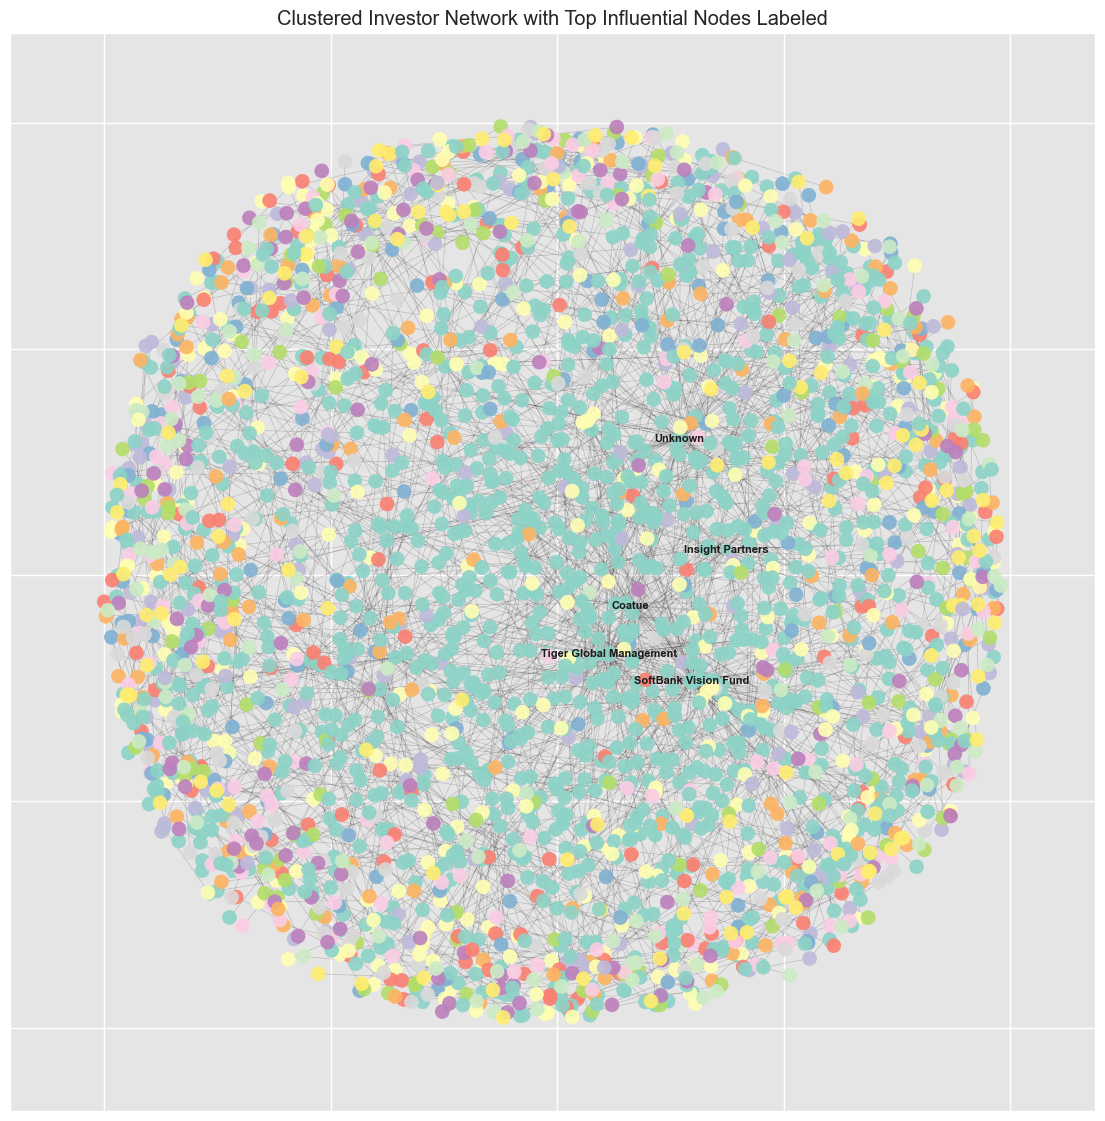

In [46]:
# Plotting with customized layout and transparency
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42, k=0.15)  # Adjust k for more spacing

# Draw nodes with community colors and centrality-based sizing
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, cmap=plt.cm.Set3, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight='bold')

plt.title("Clustered Investor Network with Top Influential Nodes Labeled")
plt.show()